In [1]:
import os
import re

import pandas as pd

import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, roc_auc_score

import seaborn as sns

from matplotlib import pyplot as plt

from utils import CreateFeatures, Selector

In [2]:
df_train = pd.read_csv('df_train.csv', index_col=0)

In [3]:
# X_train = df_train[['text']]
# y_train = df_train['label']

X_train = df_train[['text', 'box_0', 'box_1']]
y_train = df_train['label']

In [4]:
pipe_preprocessing = Pipeline([('create_feats', CreateFeatures(text_col='text'))])

In [5]:
pipe_selector = Pipeline([('select_feats', Selector(cols_to_drop=['text']))])

[Multiclass classifiers](https://scikit-learn.org/stable/modules/multiclass.html)

In [6]:
pipe_clf = Pipeline([('clf', ExtraTreesClassifier(n_estimators=25, random_state=0))])

In [7]:
pipe = Pipeline([('create_feats', pipe_preprocessing),
                 ('select_feats', pipe_selector),
                 ('clf', pipe_clf)])

In [8]:
y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

In [9]:
len(y_pred)

7411

[Performance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [10]:
label_order = ['question', 'answer', 'header', 'other']

In [11]:
cf_matrix = confusion_matrix(y_train, y_pred, labels=label_order)
cf_matrix_df = pd.DataFrame(data=cf_matrix, index=label_order, columns=label_order)

In [12]:
#cf_matrix_df

In [13]:
sum_cols = cf_matrix_df.sum(axis=0).rename('cols sum').to_frame().T
sum_rows =cf_matrix_df.sum(axis=1).rename('rows sum').to_frame()
cf_matrix_df_sums = pd.concat([cf_matrix_df, sum_cols]).join(sum_rows)

In [14]:
cf_matrix_df_sums

,question,answer,header,other,rows sum
question,2593,527,73,73,3266.0
answer,639,1950,30,183,2802.0
header,228,84,112,17,441.0
other,218,340,25,319,902.0
cols sum,3678,2901,240,592,NaN


[Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

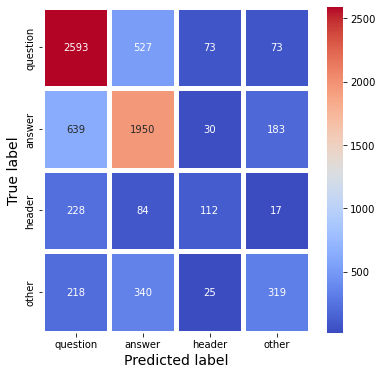

In [15]:
plt.figure(figsize=(6,6))
sns.heatmap(data=cf_matrix_df, annot=True, fmt="d",cmap='coolwarm', linewidths=5)
plt.ylabel('True label', **{'size':'14'})
plt.xlabel('Predicted label', **{'size':'14'})
plt.show()

In [16]:
f1_score(y_train, y_pred, labels=['question', 'answer'], average='weighted')

0.7177491833923566

In [17]:
f1_score(y_train, y_pred, labels=['question'], average='weighted')

0.7468317972350231

In [18]:
f1_score(y_train, y_pred, labels=['answer'], average='weighted')

0.683850604944766

In [19]:
print(classification_report(y_train, y_pred, labels=label_order))

              precision    recall  f1-score   support

    question       0.71      0.79      0.75      3266
      answer       0.67      0.70      0.68      2802
      header       0.47      0.25      0.33       441
       other       0.54      0.35      0.43       902

    accuracy                           0.67      7411
   macro avg       0.60      0.52      0.55      7411
weighted avg       0.66      0.67      0.66      7411



## What evaluation metric to use?  

Let’s have an extreme example here. Suppose you are using a search engine to search web pages by some keywords. If the search engine returns only one webpage, which is the most relevant ones, we consider the precision as 100%. However, the recall will be very low because there will be a considerable amount of web pages that are relevant (positive) but were ignored (False Negative, FN). Let’s go back to the definition of recall, TP is only 1, but FN is very large, so the denominator is extremely large whereas the nominator is very small.

On the other hand, if the search engine returns all the web pages (imagine that we don’t do “retrieving” here, simply return all webpages on the internet), the recall will be 100%, but the precision will be close to 0%. This is because the False Positive (FP) is extremely large.

Therefore, most of the time, we need to balance these two metrics. In different scenarios, we may try to improve either of them and have some trade-off on the other one.



The `scikit-learn` package includes most of the **validation metrics for classification** we will ever use (which can mostly found [here](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). 

The validation metrics for classification presented in this notebook are:
- Accuracy Score
- Confusion Matrix
- Precision
- Recall
- F1-Score
- Area Under the Receiver Operating Charactristic curve (AUROC)


**Precision** is the ability to be a good classifier on the positive prediction. Appropriate when the cost of false positives is high. Leads to **higher decision thresholds**.  

$$ P = \frac{True\ Positive}{Positive\ predictions} = \frac{TP}{TP+FP} $$  

If the search engine returns only one webpage, which is the most relevant ones, we consider the precision as 100%. However, the recall will be very low because there will be a considerable amount of web pages that are relevant (positive) but were ignored (False Negative, FN).

**Recall** is the ability to be a good classifier on the positive observations. Appropriate when the cost of false negatives is high. Leads to **lower decision thresholds**.  

$$ R = \frac{True\ Positive}{Positive\ observations} = \frac{TP}{TP+FN} $$  

On the other hand, if the search engine returns all the web pages (imagine that we don’t do “retrieving” here, simply return all webpages on the internet), the recall will be 100%, but the precision will be close to 0%. This is because the False Positive (FP) is extremely large.

**F1 score** is an attempt to find a "midground" between precision and recall. However it should be used with caution, as it assumes that both False Positives and False Negatives have the same impact on the end objective, which in a real scenario is rarely true.   

$$ F1 = 2\frac{P \times R}{P+R} $$